In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import mediapipe as mp
import seaborn as sns
import matplotlib.pyplot as plt
import threading

from tensorflow import keras
from tensorflow.keras import layers, backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
)
from tensorflow.keras.utils import get_custom_objects, to_categorical
from tensorflow.keras.applications import ResNet50  # Using ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from keras_vggface.vggface import VGGFace  # Import VGGFace2 Model
from keras_vggface.utils import preprocess_input

# Suppress TensorFlow logs (only show errors)
tf.get_logger().setLevel('ERROR')


In [2]:
# Load the dataset
labels_df = pd.read_csv('AffectNet/labels.csv')

# Stratified train-test split to maintain class balance
train_df, val_df = train_test_split(labels_df, test_size=0.2, random_state=52, stratify=labels_df['label'])

print("Training Dataset : " + str(train_df['label'].value_counts()))
print("Validation Dataset : " + str(val_df['label'].value_counts()))

# Initialize face detection model
mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# Set the target image size (IMG_SIZE)
IMG_SIZE = 224

Training Dataset : label
surprise    3693
happy       3469
anger       2886
disgust     2778
contempt    2595
fear        2434
sad         2396
neutral     2289
Name: count, dtype: int64
Validation Dataset : label
surprise    923
happy       867
anger       722
disgust     694
contempt    649
fear        609
sad         599
neutral     572
Name: count, dtype: int64


I0000 00:00:1741458268.685506 1252289 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1741458268.791779 1252386 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.183.06), renderer: NVIDIA TITAN Xp/PCIe/SSE2


In [3]:
lock = threading.Lock()
def detect_and_crop_face(image):
    """Detects and crops the face using BlazeFace (MediaPipe), then resizes to target size."""
    with lock:
        if image is None:
            print("Empty")
            
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with face detection
        results = face_detector.process(img_rgb)
    
        if results.detections:
            for detection in results.detections:
                bboxC = detection.location_data.relative_bounding_box
                h, w, _ = image.shape
    
                # Calculate bounding box coordinates
                x_min = int(bboxC.xmin * w)
                y_min = int(bboxC.ymin * h)
                box_width = int(bboxC.width * w)
                box_height = int(bboxC.height * h)
    
                # Optionally expand the bounding box slightly
                x_min = max(0, x_min - box_width // 10)
                y_min = max(0, y_min - box_height // 10)
                box_width = min(w, box_width + box_width // 5)
                box_height = min(h, box_height + box_height // 5)
    
                # Crop the face from the image using the bounding box
                cropped_face = image[y_min:y_min + box_height, x_min:x_min + box_width]
                
                # Resize the cropped face to the target size (IMG_SIZE x IMG_SIZE)
                return cv2.resize(cropped_face, (IMG_SIZE, IMG_SIZE))
    
        # If no face detected, return resized version of the original image
        return cv2.resize(image, (IMG_SIZE, IMG_SIZE))

In [4]:
# Define emotion labels
emotion_labels = ['anger', 'contempt', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
num_classes = len(emotion_labels)  # 8 classes

def image_generator(dataframe, batch_size=32):
    while True:
        batch_images = []
        batch_labels = []
        
        dataframe = dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle at start of epoch

        for i in range(len(dataframe)):
            row = dataframe.iloc[i]
            img_path = os.path.join('AffectNet', row['pth'])  # Ensure path correctness
            image = cv2.imread(img_path)

            # Detect and crop the face
            face = detect_and_crop_face(image)
            if face is not None:
                batch_images.append(face)

                # Convert label from string to index
                label_str = row['label']
                if label_str not in emotion_labels:
                    print(f"Warning: Unexpected label '{label_str}' found!")
                    continue  # Skip if label is not in predefined list

                label_index = emotion_labels.index(label_str) 

                one_hot_label = to_categorical(label_index, num_classes=num_classes)

                batch_labels.append(one_hot_label)

            # Yield batch when full
            if len(batch_images) == batch_size:
                yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)
                batch_images = []
                batch_labels = []

        # Yield remaining images if any
        if len(batch_images) > 0:
            yield np.array(batch_images).astype('float32') / 255.0, np.array(batch_labels)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1741458268.852946 1252379 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [5]:
x_batch, y_batch = next(image_generator(train_df, batch_size=32))
print("Batch X shape:", x_batch.shape)  
print("Batch Y shape:", y_batch.shape) 

Batch X shape: (32, 224, 224, 3)
Batch Y shape: (32, 8)


In [6]:
# CNN Feature Extractor 1
def create_cnn_feature_extractor_1():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(8, (75, 75), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (50, 50), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (25, 25), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (15, 15), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (9, 9), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_1")

# Mixture of Experts (MoE)
def create_moe(input_dim, num_experts=4, top_k=2, name="MoE"):
    inputs = keras.Input(shape=(input_dim,))
    experts = [layers.Dense(input_dim, activation="relu") for _ in range(num_experts)]
    
    gating_logits = layers.Dense(num_experts)(inputs)
    gating = layers.Softmax()(gating_logits)
    
    expert_outputs = tf.stack([experts[i](inputs) for i in range(num_experts)], axis=1)
    top_k_values, top_k_indices = tf.math.top_k(gating, k=top_k)

    output = tf.zeros_like(inputs)
    for i in range(top_k):
        expert_idx = top_k_indices[:, i]
        expert_out = tf.gather(expert_outputs, expert_idx, axis=1, batch_dims=1)
        output += tf.expand_dims(top_k_values[:, i], -1) * expert_out
    
    return keras.Model(inputs, output, name=name)

# CNN Feature Extractor 2
def create_cnn_feature_extractor_2():
    inputs = keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(16, (15, 15), activation="relu", padding="same")(inputs)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (7, 7), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (5, 5), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)
    return keras.Model(inputs, x, name="CNNFeatureExtractor_2")

# ResNet50
def create_resnet_model():
    inputs = keras.Input(shape=(224, 224, 3))
    x = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')(inputs)
    x = layers.Dropout(0.5)(x)
    return keras.Model(inputs, x, name="ResNet50")

# Complete FER Model
def create_fer_model(num_classes=7):
    inputs = keras.Input(shape=(224, 224, 3))
    
    cnn_model_1 = create_cnn_feature_extractor_1()
    cnn_model_2 = create_cnn_feature_extractor_2()
    resnet50_model = create_resnet_model()
    
    cnn_features_1 = cnn_model_1(inputs)
    cnn_features_2 = cnn_model_2(inputs)
    resnet50_features = resnet50_model(inputs)
    
    combined_features = layers.Concatenate()([cnn_features_2, resnet50_features])
    dense_layer = layers.Dense(512, activation="relu")(combined_features)
    dense_layer = layers.Dropout(0.5)(dense_layer)
    
    cnn_moe = create_moe(512, name="MoE_CNN_Features")(cnn_features_1)
    expression_moe = create_moe(512, name="MoE_Expression")(dense_layer)
    
    final_features = layers.Concatenate()([cnn_moe, expression_moe])
    output = layers.Dense(num_classes, activation="softmax")(final_features)
    
    return keras.Model(inputs, output, name="ExpressNet-MoE")

# Compile and Initialize Model
# Enable Multi-GPU Training
strategy = tf.distribute.MirroredStrategy()

# Define Model within Strategy Scope
with strategy.scope():
    num_classes = 8
    model = create_fer_model(num_classes)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=loss, 
                  metrics=["accuracy"])

# Update model checkpoint to save the best model based on validation accuracy
checkpoint = ModelCheckpoint('AffectNet8-Ensemble-Vision.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Reduce LR by 5% every epoch
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False, verbose=1)

model.summary()


Model: "ExpressNet-MoE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 CNNFeatureExtractor_2 (Functio  (None, 256)         458208      ['input_1[0][0]']                
 nal)                                                                                             
                                                                                                  
 ResNet50 (Functional)          (None, 2048)         23561152    ['input_1[0][0]']                
                                                                                     

In [7]:
history = model.fit(
    image_generator(train_df, batch_size=32),
    steps_per_epoch=len(train_df) // 32,
    epochs=15,
    validation_data=image_generator(val_df, batch_size=32),
    validation_steps=len(val_df) // 32,
    callbacks=[checkpoint, lr_callback, early_stopping] 
)

Epoch 1/15
704/704 [==============================] - ETA: 0s - loss: 1.6176 - accuracy: 0.4768
Epoch 1: val_accuracy improved from -inf to 0.48207, saving model to AffectNet8-Ensemble-Vision.h5
704/704 [==============================] - 570s 674ms/step - loss: 1.6176 - accuracy: 0.4768 - val_loss: 1.6025 - val_accuracy: 0.4821 - lr: 9.5000e-05
Epoch 2/15
704/704 [==============================] - ETA: 0s - loss: 1.1888 - accuracy: 0.6752
Epoch 2: val_accuracy improved from 0.48207 to 0.70694, saving model to AffectNet8-Ensemble-Vision.h5
704/704 [==============================] - 481s 675ms/step - loss: 1.1888 - accuracy: 0.6752 - val_loss: 1.1035 - val_accuracy: 0.7069 - lr: 9.0250e-05
Epoch 3/15
704/704 [==============================] - ETA: 0s - loss: 1.0277 - accuracy: 0.7545
Epoch 3: val_accuracy did not improve from 0.70694
704/704 [==============================] - 468s 665ms/step - loss: 1.0277 - accuracy: 0.7545 - val_loss: 1.1689 - val_accuracy: 0.6773 - lr: 8.5737e-05
Epoc

In [8]:
import os
import cv2
import numpy as np

def preprocess_and_predict_concatenated_model(model, dataframe):
    images = []
    labels = []

    # List of emotion labels corresponding to each model output
    emotion_labels = ['anger', 'contempt', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']

    # Loop through each row of the dataframe
    for _, row in dataframe.iterrows():
        img_path = os.path.join('AffectNet', row['pth'])
        image = cv2.imread(img_path)

        # Apply face detection and cropping
        face = detect_and_crop_face(image)
        if face is not None:
            images.append(face.astype('float32') / 255.0)  # Normalize image to [0, 1]
            
            # Convert label to binary vector for each emotion
            labels.append([1 if row['label'] == emotion else 0 for emotion in emotion_labels])

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Predict using the concatenated model
    y_pred = model.predict(images)

    # Use argmax to find the index of the highest output for each prediction
    predicted_indices = np.argmax(y_pred, axis=-1)  # Get index of the highest value (emotion)

    # Map the predicted indices to emotion labels
    predicted_emotions = [emotion_labels[i] for i in predicted_indices]

    return labels, predicted_emotions  # Return both true labels and predicted emotions


In [9]:
model.load_weights('AffectNet8-Ensemble-Vision.h5')

In [10]:
y_true, y_pred_classes = preprocess_and_predict_concatenated_model(model, val_df)

177/177 [==============================] - 42s 211ms/step


In [11]:
# Convert true labels from binary vectors to emotion labels
emotion_labels = ['anger', 'contempt', 'disgust', 'sad', 'happy', 'fear', 'neutral', 'surprise']
y_true_labels = [' '.join([emotion_labels[i] for i, val in enumerate(row) if val == 1]) for row in y_true]

# Print classification report
print("Classification Report:")
print(classification_report(y_true_labels, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

       anger       0.83      0.55      0.66       722
    contempt       0.69      0.76      0.72       649
     disgust       0.68      0.72      0.70       694
        fear       0.90      0.59      0.71       609
       happy       0.89      0.84      0.86       867
     neutral       0.55      0.73      0.62       572
         sad       0.62      0.75      0.68       599
    surprise       0.74      0.80      0.77       923

    accuracy                           0.73      5635
   macro avg       0.74      0.72      0.72      5635
weighted avg       0.75      0.73      0.73      5635



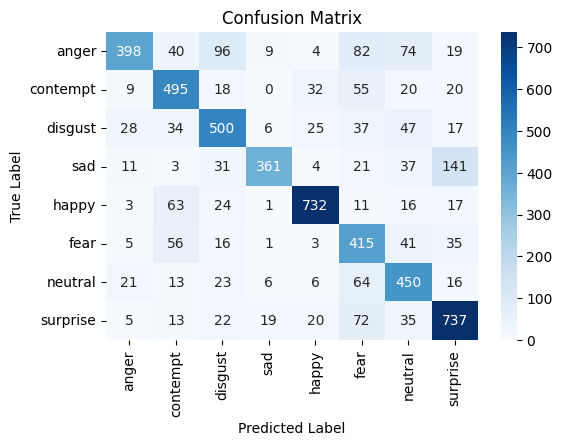

In [12]:
# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_classes)

# Plot using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

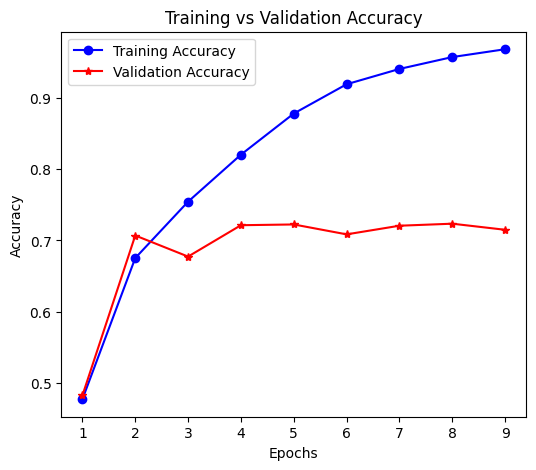

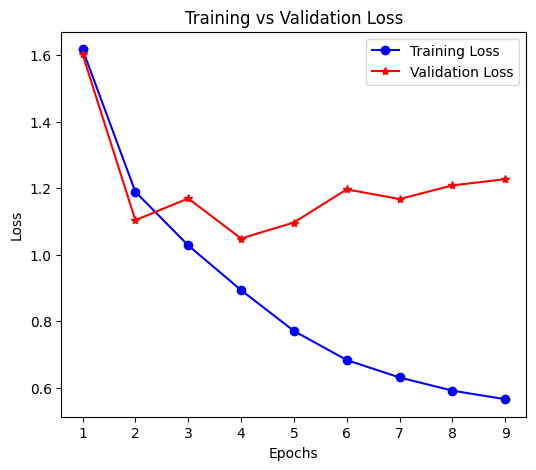

In [13]:
import matplotlib.pyplot as plt

# Define epochs based on history length
epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Training vs Validation Accuracy
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Plot Training vs Validation Loss
plt.figure(figsize=(6, 5))
plt.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r*-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [15]:
import json
import numpy as np

# Convert history values to Python float
history_dict = {key: [float(val) for val in values] for key, values in history.history.items()}

# Save the converted dictionary as JSON
with open('training_history_AffectNet-8.json', 'w') as f:
    json.dump(history_dict, f)


In [16]:
from sklearn.metrics import accuracy_score\
# Convert one-hot encoded y_true to numerical indices
y_true_indices = np.argmax(y_true, axis=-1)

# Convert predicted emotion labels to numerical indices
y_pred_indices = [emotion_labels.index(pred) for pred in y_pred_classes]

accuracy = accuracy_score(y_true_indices, y_pred_indices)

print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7255
